In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy, random, pathlib, os, time
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim

## 1D dataset

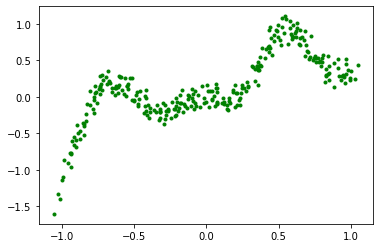

In [2]:
x = np.linspace(1e-5,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
# y = y*0.4

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = torch.Tensor(x.reshape(-1,1))
yy = torch.Tensor(y.reshape(-1,1))

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [198]:
class NormalizedProjectedSGD(optim.Optimizer):
    
    def __init__(self, params, lr=5, initial_lr=0.01):
        
        defaults = dict(lr=lr, initial_lr=initial_lr)
        super().__init__(params, defaults)
        
        self.params = []
        for group in self.param_groups:
            for p in group['params']:
                self.params.append(p)
        
        ## initialize random previous gradient
        self.prev_grads = 0
        for p in self.params:
            self.prev_grads += torch.numel(p.data)
        self.prev_grads = torch.randn(self.prev_grads)
        self.prev_grads /= torch.norm(self.prev_grads)
            
        ## this is previous local learning rate
        self.prev_lr = initial_lr
        self.lr = lr
        self.mp = 0
        self.m = 0
        
    def __setstate__(self, state):
        super().__setstate__(state)
        
    def _get_concatenated_grads_(self):
        params = []
        for p in self.params:
            if p.grad is None: continue
            params.append(p.grad.reshape(-1))
        params = torch.cat(params)
        return params
    
    def _get_normalized_gradients_(self):
        ngrads = self._get_concatenated_grads_()
        gnorm = torch.norm(ngrads)
        for p in self.params:
            if p.grad is None: continue
            p.grad /= gnorm
        ngrads /= gnorm
        return ngrads
        
    @torch.no_grad()
    def step(self):
        ngrads = self._get_normalized_gradients_()
        
        multiplier = float(ngrads@self.prev_grads)
        self.mp = multiplier
        
        multiplier = (2**multiplier)#*1.5
#         multiplier = 1.2*(2**multiplier)-0.5
#         multiplier = 0.13*np.tan(1.4*multiplier) + 0.25*multiplier + 1.104
#         multiplier = ((2**multiplier)-0.25)/1.1666666
        self.m = multiplier

        self.prev_grads = ngrads
        cur_lr = self.prev_lr*multiplier
        self.prev_lr = cur_lr
        
        cur_lr = self.lr*cur_lr
        for p in self.params:
            p -= cur_lr*p.grad
        return       

## 2D dataset

In [120]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
# X1 = np.linspace(-2.5, 0, num_points)
X2 = np.linspace(-2, 4, num_points)
# X2 = np.linspace(-2, 2, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

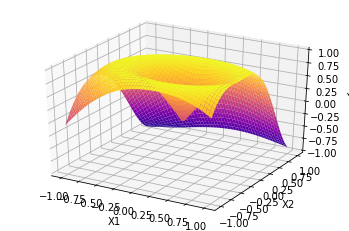

In [121]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
# Y = -Y

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [122]:
actf = nn.LeakyReLU
# actf = nn.ELU

# torch.manual_seed(123)
net = nn.Sequential(nn.Linear(2,10),
                    actf(),
                    nn.Linear(10,10),
                    actf(),
                    nn.Linear(10,1))

In [123]:
optimizer = NormalizedProjectedSGD(net.parameters(), lr=1, initial_lr=0.01)
# optimizer = optim.SGD(net.parameters(), lr=0.05*2)
# optimizer = optim.Adam(net.parameters(), lr=0.005)


criterion = nn.MSELoss()

In [124]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

for epoch in range(10000):
    yout = net(xx)    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if epoch%100 == 0:
        if isinstance(optimizer, NormalizedProjectedSGD):
            print(f'Epoch: {epoch}, Loss:{float(loss)}, LR: {float(optimizer.prev_lr)}, mp: {optimizer.mp}, m: {optimizer.m}')
        else:
            print(f'Epoch: {epoch}, Loss:{float(loss)}')

        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.506640613079071, LR: 0.017071662946608637, mp: 0.18664109706878662, m: 1.7071662946608634


Epoch: 100, Loss:0.030859820544719696, LR: 0.00972080451688154, mp: -0.5943945646286011, m: 0.9934835164675438


Epoch: 200, Loss:0.02642563171684742, LR: 0.0038841880076397536, mp: -0.602713406085968, m: 0.9877713945851936


Epoch: 300, Loss:0.025733444839715958, LR: 0.0018168356558314284, mp: -0.5935404896736145, m: 0.9940718324828833


Epoch: 400, Loss:0.02552434429526329, LR: 0.001166732959832118, mp: -0.5886094570159912, m: 0.9974753149183117


Epoch: 500, Loss:0.025427429005503654, LR: 0.0008857505192989176, mp: -0.5852688550949097, m: 0.9997876738739636


Epoch: 600, Loss:0.02535947412252426, LR: 0.0008099698075559053, mp: -0.5835144519805908, m: 1.0010042147881948


Epoch: 700, Loss:0.025294145569205284, LR: 0.0008481673369624528, mp: -0.5847089290618896, m: 1.0001757779278202


Epoch: 800, Loss:0.02521592378616333, LR: 0.0009598134373210301, mp: -0.5832227468490601, m: 

TclError: invalid command name "pyimage360"

In [99]:
## [2,10,1]
## Ours 0.05
# Epoch: 9900, Loss:0.021343465894460678, LR: 0.03529319427811438

## SGD 0.05
# Epoch: 9900, Loss:0.020099615678191185

## Adam 0.05
# Epoch: 9900, Loss:0.013111154548823833


## [2, 20, 1]
## Ours 10, 0.005
# (when sub 0.25 & rescaled by 1.16666 )
# Epoch: 9900, Loss:0.0032474282197654247, LR: 8.435401519436253e-06

# (when pow 2)
# Epoch: 9900, Loss:0.0019135525217279792, LR: 2.642544804891798e-05
# Epoch: 9900, Loss:0.0029165581800043583, LR: 0.005360392112688018

## ours 1, 0.05
# Epoch: 9900, Loss:0.002716632792726159, LR: 0.0001498379517862916


## SGD 0.1
# Epoch: 9900, Loss:0.0032017379999160767

## Adam 0.005
# Epoch: 9900, Loss:0.0020291260443627834


In [ ]:
## [2, 10, 10, 1]

## ours (2** multiplier) 10, 0.05
# Epoch: 9900, Loss:0.0017440285300835967, LR: 0.00083682145017325

## ours () 1, 0.05
# Epoch: 9900, Loss:0.0037328838370740414, LR: 0.011594755421987273

## SGD 0.1
# Epoch: 9900, Loss:0.004599684849381447

## Adam 0.005
# Epoch: 9900, Loss:0.0004339274310041219

## normalize grads in adam

In [169]:
# actf = nn.LeakyReLU
actf = nn.ELU

torch.manual_seed(2)
net = nn.Sequential(nn.Linear(2,10),
                    actf(),
                    nn.Linear(10,10),
                    actf(),
                    nn.Linear(10,1))

In [170]:
# optimizer = optim.SGD(net.parameters(), lr=0.05*2)
params = list(net.parameters())
optimizer = optim.Adam(params, lr=0.001)

criterion = nn.MSELoss()

In [171]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

for epoch in range(10000):
    yout = net(xx)    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    
#     cp = []
#     for p in params:
#         if p.grad is None: continue
#         cp.append(p.grad.reshape(-1))
#     cp = torch.cat(cp)
#     norm = torch.norm(cp)
#     for p in params:
#         if p.grad is None: continue
#         p.grad /= norm
        
    optimizer.step()
   
    if epoch%100 == 0:
        if isinstance(optimizer, NormalizedProjectedSGD):
            print(f'Epoch: {epoch}, Loss:{float(loss)}, LR: {float(optimizer.prev_lr)}, mp: {optimizer.mp}, m: {optimizer.m}')
        else:
            print(f'Epoch: {epoch}, Loss:{float(loss)}')

        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.8222292065620422


Epoch: 100, Loss:0.1750761717557907


Epoch: 200, Loss:0.13993549346923828


Epoch: 300, Loss:0.13150233030319214


Epoch: 400, Loss:0.12063942849636078


Epoch: 500, Loss:0.10435755550861359


Epoch: 600, Loss:0.08035203069448471


Epoch: 700, Loss:0.05364639312028885


Epoch: 800, Loss:0.04158272221684456


Epoch: 900, Loss:0.039811719208955765


Epoch: 1000, Loss:0.039338041096925735


Epoch: 1100, Loss:0.0390501543879509


Epoch: 1200, Loss:0.03880367428064346


Epoch: 1300, Loss:0.03853719308972359


Epoch: 1400, Loss:0.03819222375750542


Epoch: 1500, Loss:0.037663303315639496


Epoch: 1600, Loss:0.03675461560487747


Epoch: 1700, Loss:0.035209327936172485


Epoch: 1800, Loss:0.03289687633514404


Epoch: 1900, Loss:0.030337976291775703


Epoch: 2000, Loss:0.0286199189722538


Epoch: 2100, Loss:0.02780609391629696


Epoch: 2200, Loss:0.027296554297208786


Epoch: 2300, Loss:0.0268437247723341


Epoch: 2400, Loss:0.026387164369225502


Epoch: 250

In [152]:
#n Epoch: 9900, Loss:0.0005544277955777943
# Epoch: 9900, Loss:0.0005544277955777943

#n Epoch: 9900, Loss:0.0015181787312030792
# Epoch: 9900, Loss:0.001026982325129211

#n Epoch: 9900, Loss:0.0004426918167155236
# Epoch: 9900, Loss:0.0007030770066194236



## MNIST

In [172]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [199]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [200]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [201]:
def shuffle_data():
    global train_data, train_label
    randidx = random.sample(range(len(train_label)), k=len(train_label))
    train_data = train_data[randidx]
    train_label = train_label[randidx]

In [202]:
input_size = 784
output_size = 10

batch_size = 50

In [206]:
actf = nn.LeakyReLU
# actf = nn.ELU

net = nn.Sequential(nn.Linear(784,300),
                         actf(),
                         nn.Linear(300,100),
                         actf(),
                         nn.Linear(100,10),
                        )

In [207]:
optimizer = NormalizedProjectedSGD(net.parameters(), lr=0.1, initial_lr=0.001)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [208]:
%matplotlib tk

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

losses = []
train_accs = []
test_accs = []

for epoch in range(20):
    train_acc = 0
    train_count = 0
    shuffle_data()
    for index in range(train_size // batch_size):

        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]

        yout = net(train_x)    
        loss = criterion(yout, train_y)
        losses.append(float(loss))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        targets = train_y.data.cpu().numpy()

        correct = (outputs == targets).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

        if index%1 == 0:
            train_accs.append(float(train_acc)/train_count*100)
            train_acc = 0
            train_count = 0
            
            print(optimizer.mp, optimizer.m)
            print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}, lr: {float(optimizer.prev_lr)}')
            yout = net(test_data)
            outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
            targets = test_label.data.cpu().numpy()

            correct = (outputs == targets).astype(float).sum()
            test_accs.append(float(correct)/len(outputs)*100)

            print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
            
            ax.clear()
            ax.plot(losses)

            fig.canvas.draw()
            plt.pause(0.01)
            print("\n")

0.0024968720972537994 1.0017321983797978
Epoch: 0:0,  Loss:2.296860456466675, lr: 0.0010017321983797978
Train Acc:14.00%, Test Acc:12.57%


0.3211723566055298 1.2493453741497547
Epoch: 0:1,  Loss:2.277890920639038, lr: 0.0012515094881826647
Train Acc:12.00%, Test Acc:12.57%


0.260276198387146 1.1977079792328365
Epoch: 0:2,  Loss:2.291736602783203, lr: 0.0014989429000819808
Train Acc:18.00%, Test Acc:12.59%


0.2281446009874344 1.1713275772252731
Epoch: 0:3,  Loss:2.320108413696289, lr: 0.0017557531555520514
Train Acc:8.00%, Test Acc:12.59%


0.1150130107998848 1.0829848122713108
Epoch: 0:4,  Loss:2.299194812774658, lr: 0.0019014540015603
Train Acc:12.00%, Test Acc:12.58%


0.13619586825370789 1.0990034142273768
Epoch: 0:5,  Loss:2.306901454925537, lr: 0.0020897044397110774
Train Acc:12.00%, Test Acc:12.59%


0.00855381041765213 1.0059466611779522
Epoch: 0:6,  Loss:2.2980775833129883, lr: 0.0021021312039761018
Train Acc:8.00%, Test Acc:12.58%


0.3319131135940552 1.2586813670521042
Epo



-0.415252685546875 0.7498881415261391
Epoch: 0:61,  Loss:0.9762929677963257, lr: 0.8502759172862409
Train Acc:82.00%, Test Acc:78.99%


0.342430055141449 1.2678904130747732
Epoch: 0:62,  Loss:0.9037878513336182, lr: 1.0780566839955836
Train Acc:76.00%, Test Acc:77.46%


-0.15566855669021606 0.8977162674120324
Epoch: 0:63,  Loss:0.7933926582336426, lr: 0.9677890224151082
Train Acc:80.00%, Test Acc:78.87%


0.0753214880824089 1.053595791564371
Epoch: 0:64,  Loss:0.8712392449378967, lr: 1.0196584411387548
Train Acc:86.00%, Test Acc:76.32%


-0.0792514979839325 0.946548609654904
Epoch: 0:65,  Loss:0.9423779845237732, lr: 0.9651562797827751
Train Acc:78.00%, Test Acc:78.42%


-0.2758672535419464 0.8259536597756854
Epoch: 0:66,  Loss:1.0939618349075317, lr: 0.7971743615420684
Train Acc:60.00%, Test Acc:78.41%


0.2275809943675995 1.1708700730243022
Epoch: 0:67,  Loss:0.9737889170646667, lr: 0.9333876029118632
Train Acc:72.00%, Test Acc:75.72%


-0.15637317299842834 0.8972779273187466
Epoch

Train Acc:92.00%, Test Acc:82.88%


0.06906957924365997 1.0490399201409655
Epoch: 0:121,  Loss:0.8501657843589783, lr: 0.37867606041190177
Train Acc:74.00%, Test Acc:82.50%


0.1862926185131073 1.1378359891229515
Epoch: 0:122,  Loss:0.6831696033477783, lr: 0.43087124975595875
Train Acc:76.00%, Test Acc:81.11%


-0.5460445880889893 0.684895322206765
Epoch: 0:123,  Loss:0.5578991770744324, lr: 0.29510170343123887
Train Acc:88.00%, Test Acc:82.00%


0.34051868319511414 1.2662117453975823
Epoch: 0:124,  Loss:0.7068778276443481, lr: 0.3736612429714687
Train Acc:84.00%, Test Acc:82.65%


0.12209472805261612 1.0883138985406202
Epoch: 0:125,  Loss:0.7166860103607178, lr: 0.40666072407181303
Train Acc:70.00%, Test Acc:82.70%


-0.36673879623413086 0.7755336060542882
Epoch: 0:126,  Loss:0.7150158882141113, lr: 0.31537905778006103
Train Acc:78.00%, Test Acc:83.03%


-0.15272673964500427 0.8995486792083113
Epoch: 0:127,  Loss:0.6533235907554626, lr: 0.2836988148760156
Train Acc:88.00%, Test Acc:82

Train Acc:86.00%, Test Acc:84.77%


0.41977545619010925 1.33771933339214
Epoch: 0:181,  Loss:0.7523599863052368, lr: 0.14265805185262836
Train Acc:78.00%, Test Acc:84.76%


0.0711943656206131 1.0505860736160164
Epoch: 0:182,  Loss:0.6189632415771484, lr: 0.14987456256556292
Train Acc:80.00%, Test Acc:84.81%


-0.05122446268796921 0.9651168548284369
Epoch: 0:183,  Loss:0.6927939057350159, lr: 0.14464646644206386
Train Acc:78.00%, Test Acc:84.69%


-0.4332157373428345 0.7406091417186127
Epoch: 0:184,  Loss:0.8255031704902649, lr: 0.10712649536428703
Train Acc:86.00%, Test Acc:84.68%


-0.1086534634232521 0.9274532947530103
Epoch: 0:185,  Loss:0.5892102122306824, lr: 0.09935482108095109
Train Acc:82.00%, Test Acc:84.64%


0.026991242542862892 1.0188850117553023
Epoch: 0:186,  Loss:0.7174439430236816, lr: 0.10123113804501081
Train Acc:86.00%, Test Acc:84.54%


0.19893775880336761 1.1478528917615154
Epoch: 0:187,  Loss:0.45209744572639465, lr: 0.11619845454127482
Train Acc:94.00%, Test Acc:

TclError: invalid command name "pyimage609"